# Volatility Regime Detection and Trading Strategy Using Hidden Markov Models

This notebook implements a volatility regime detection system using a 3-state Gaussian Hidden Markov Model (HMM) and backtests a regime-based trading strategy.

**Approach:**
1. Fit a 3-state HMM to detect **LOW**, **MID**, and **HIGH** volatility regimes
2. Apply a pre-defined long/short strategy based on external analysis of stock performance in each regime
3. Calculate backtest statistics (Sharpe, Sortino, CAGR, Max Drawdown)

**Excluded Stocks:** F, G, J (as specified)

## 1. Setup and Data Loading

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Parameters
N_STATES = 3
N_ITER = 3000
N_RESTARTS = 30
ROLL_VOL_WINDOW = 30
EXCLUDED_STOCKS = ['F', 'G', 'J']

In [68]:
# Load price data
prices = pd.read_csv('simulated_prices.csv', index_col='Date')

# Remove excluded stocks
prices = prices.drop(columns=EXCLUDED_STOCKS, errors='ignore')

# Calculate daily returns
rets = prices.pct_change().dropna()

# Market return (equal-weight of included stocks)
mkt_ret = rets.mean(axis=1)

print(f"Data: {len(prices)} days, {prices.columns.tolist()}")
print(f"Excluded: {EXCLUDED_STOCKS}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print(f"Number of stocks: {len(prices.columns)}")

Data: 2521 days, ['A', 'B', 'C', 'D', 'E', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Excluded: ['F', 'G', 'J']
Date range: Y0-M01-D02 to Y9-M08-D30
Number of stocks: 22


## 2. HMM Volatility Regime Detection

We fit a 3-state Gaussian HMM on the **absolute returns** of the market index. The states are labeled by their emission variance:
- **LOW**: Lowest variance state (calm markets)
- **MID**: Medium variance state (normal markets)  
- **HIGH**: Highest variance state (volatile markets)

In [69]:
def fit_hmm_volatility_regime(series: pd.Series, n_states=3, n_iter=3000, n_restarts=30):
    """
    Fit a Gaussian HMM on absolute returns to detect volatility regimes.
    
    Parameters:
    -----------
    series : pd.Series
        Return series (e.g., market returns)
    n_states : int
        Number of hidden states (default: 3 for LOW/MID/HIGH)
    n_iter : int
        Maximum iterations for EM algorithm
    n_restarts : int
        Number of random restarts to avoid local optima
        
    Returns:
    --------
    regime : pd.Series
        Regime labels ('LOW', 'MID', 'HIGH')
    probs : pd.DataFrame
        Posterior probabilities for each state
    model : GaussianHMM
        Fitted HMM model
    state_variances : np.ndarray
        Emission variances for each state
    state_mapping : dict
        Mapping from state index to label
    """
    # Use absolute returns as the observation (volatility proxy)
    x = np.abs(series.values)
    
    # Standardize for numerical stability
    x_mean, x_std = x.mean(), x.std()
    x_standardized = (x - x_mean) / (x_std + 1e-12)
    X = x_standardized.reshape(-1, 1)
    
    # Fit HMM with multiple restarts
    best_model, best_ll = None, -np.inf
    
    for seed in range(n_restarts):
        model = GaussianHMM(
            n_components=n_states,
            covariance_type="diag",
            n_iter=n_iter,
            random_state=seed,
            tol=1e-6
        )
        model.fit(X)
        ll = model.score(X)
        
        if ll > best_ll:
            best_ll, best_model = ll, model
    
    # Predict states
    states = best_model.predict(X)
    
    # Label states by emission variance (LOW = smallest variance, HIGH = largest)
    state_variances = best_model.covars_.reshape(-1)
    order = np.argsort(state_variances)
    state_mapping = {
        int(order[0]): "LOW",
        int(order[1]): "MID",
        int(order[2]): "HIGH"
    }
    
    # Create regime series
    regime = pd.Series(
        [state_mapping[int(s)] for s in states],
        index=series.index,
        name="vol_regime"
    )
    
    # Posterior probabilities
    probs = pd.DataFrame(
        best_model.predict_proba(X),
        index=series.index,
        columns=[f"p_{state_mapping.get(i, f'state_{i}')}" for i in range(n_states)]
    )
    
    return regime, probs, best_model, state_variances, state_mapping

In [70]:
# Fit the HMM
print("Fitting HMM with multiple restarts (this may take a moment)...")
vol_regime, regime_probs, hmm_model, state_vars, state_to_label = fit_hmm_volatility_regime(
    mkt_ret.dropna(),
    n_states=N_STATES,
    n_iter=N_ITER,
    n_restarts=N_RESTARTS
)

print("\nHMM Fitting Complete!")
print(f"State variances (standardized): {state_vars}")
print(f"State mapping: {state_to_label}")
print(f"\nRegime distribution:")
print(vol_regime.value_counts().reindex(['LOW', 'MID', 'HIGH']))

Fitting HMM with multiple restarts (this may take a moment)...

HMM Fitting Complete!
State variances (standardized): [0.02496745 0.93176924 0.22071498]
State mapping: {0: 'LOW', 2: 'MID', 1: 'HIGH'}

Regime distribution:
vol_regime
LOW      556
MID     1156
HIGH     808
Name: count, dtype: int64


## 3. Create Analysis DataFrame

In [71]:
# Build main analysis DataFrame
df = pd.DataFrame({'mkt_ret': mkt_ret}).dropna()
df['vol_regime'] = vol_regime
df = df.join(regime_probs)

# Add individual stock returns
df = df.join(rets)

print(f"Analysis DataFrame: {len(df)} rows, {len(df.columns)} columns")
df.head(10)

Analysis DataFrame: 2520 rows, 27 columns


,mkt_ret,vol_regime,p_LOW,p_HIGH,p_MID,A,B,C,D,E,...,P,Q,R,S,T,U,V,W,X,Y
Date,,,,,,,,,,,,,,,,,,,,,
Y0-M01-D05,-0.010026,HIGH,0.000000e+00,1.000000,5.946032e-221,0.006751,-0.010314,-0.023205,-0.028024,-0.145879,...,-0.011509,-0.006542,-0.007901,-0.040486,0.019025,-0.029488,0.012420,-0.002938,-0.000664,0.003878
Y0-M01-D06,-0.007799,MID,1.894287e-18,0.471418,5.285819e-01,-0.008480,-0.022298,-0.055354,-0.011904,-0.057710,...,0.005175,-0.003575,-0.013858,0.028724,0.016892,-0.001033,0.003863,0.018218,0.047176,0.024548
Y0-M01-D07,0.002335,MID,3.481647e-01,0.083539,5.682964e-01,0.009945,-0.002665,-0.053653,0.041774,0.063724,...,-0.015015,0.026907,0.008238,-0.019246,0.012240,0.003311,-0.014719,0.016050,-0.023477,-0.048285
Y0-M01-D08,-0.009015,HIGH,1.703237e-25,0.754549,2.454512e-01,-0.010044,0.000311,0.017286,-0.006683,-0.019814,...,0.000000,0.004137,-0.027555,-0.059514,-0.025738,-0.010621,0.002535,-0.019422,0.032489,0.017380
Y0-M01-D09,0.008274,HIGH,4.395953e-21,0.599864,4.001365e-01,0.009947,-0.000062,0.008623,0.036211,0.039477,...,0.007840,0.009522,0.009720,-0.020352,-0.018794,0.011047,0.006357,0.036532,0.015733,0.005276
Y0-M01-D12,-0.003903,MID,1.035569e-03,0.145621,8.533438e-01,-0.002364,-0.011182,0.013515,-0.027796,-0.002288,...,-0.000864,-0.000453,-0.029042,0.006809,-0.002530,0.016699,-0.045575,0.024713,0.065675,0.060602
Y0-M01-D13,0.004809,MID,4.530883e-06,0.190811,8.091844e-01,-0.015698,0.012816,0.039447,-0.006679,0.032103,...,0.000433,0.001361,0.003865,-0.006763,-0.016486,0.004461,-0.024481,-0.028178,0.011047,0.038407
Y0-M01-D14,0.003052,MID,5.194649e-02,0.118488,8.295651e-01,-0.010532,0.000868,0.056805,0.028405,0.007110,...,0.019023,-0.001631,0.015233,-0.003142,-0.014551,0.007268,0.038591,0.018506,-0.022427,0.004311
Y0-M01-D15,0.015344,HIGH,2.812348e-82,0.999976,2.435723e-05,0.017334,-0.010226,0.059793,0.043121,0.011030,...,0.011880,0.026865,-0.015993,0.023117,-0.022430,0.022748,0.076210,-0.013732,-0.006471,-0.021577


## 4. Regime Visualization

In [72]:
def shade_regime_blocks(ax, regime_series, alpha=0.2):
    """
    Shade contiguous regime blocks on a matplotlib axis.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axis to shade
    regime_series : pd.Series
        Series with regime labels indexed by date
    alpha : float
        Transparency of shading
    """
    regime_series = regime_series.dropna()
    if regime_series.empty:
        return
    
    # Color mapping for regimes
    color_map = {
        'LOW': 'green',
        'MID': 'gold',
        'HIGH': 'red'
    }
    
    # Find contiguous blocks
    start_idx = 0
    prev_regime = regime_series.iloc[0]
    
    for i, (t, regime) in enumerate(regime_series.iloc[1:].items(), 1):
        if regime != prev_regime:
            ax.axvspan(
                start_idx, i,
                alpha=alpha,
                facecolor=color_map.get(prev_regime, 'gray'),
                edgecolor='none'
            )
            start_idx = i
            prev_regime = regime
    
    # Last block
    ax.axvspan(
        start_idx, len(regime_series),
        alpha=alpha,
        facecolor=color_map.get(prev_regime, 'gray'),
        edgecolor='none'
    )

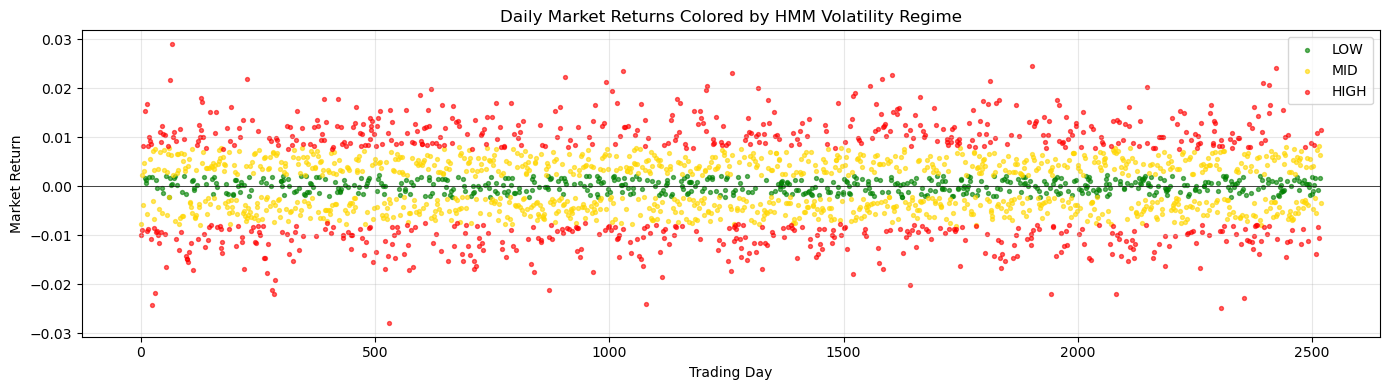

In [73]:
# Plot 1: Returns colored by regime
fig, ax = plt.subplots(figsize=(14, 4))

colors = {'LOW': 'green', 'MID': 'gold', 'HIGH': 'red'}
for regime in ['LOW', 'MID', 'HIGH']:
    mask = df['vol_regime'] == regime
    ax.scatter(
        np.where(mask)[0],
        df.loc[mask, 'mkt_ret'],
        s=8,
        c=colors[regime],
        label=regime,
        alpha=0.6
    )

ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('Trading Day')
ax.set_ylabel('Market Return')
ax.set_title('Daily Market Returns Colored by HMM Volatility Regime')
ax.legend()
plt.tight_layout()
plt.show()

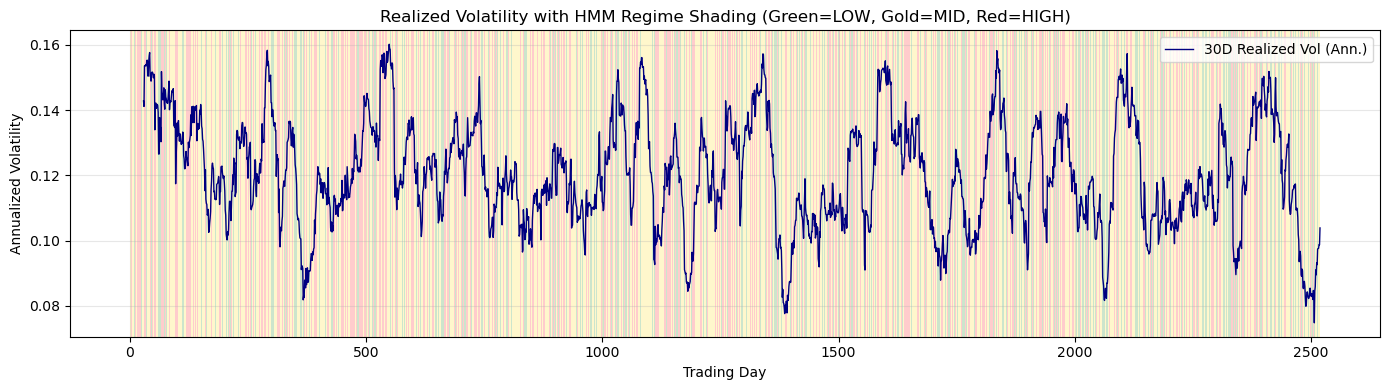

In [74]:
# Plot 2: Realized volatility with regime shading
realized_vol = df['mkt_ret'].rolling(ROLL_VOL_WINDOW).std() * np.sqrt(252)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(range(len(realized_vol)), realized_vol.values, color='navy', linewidth=1, label=f'{ROLL_VOL_WINDOW}D Realized Vol (Ann.)')

# Shade by regime
shade_regime_blocks(ax, df['vol_regime'], alpha=0.2)

ax.set_xlabel('Trading Day')
ax.set_ylabel('Annualized Volatility')
ax.set_title('Realized Volatility with HMM Regime Shading (Green=LOW, Gold=MID, Red=HIGH)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

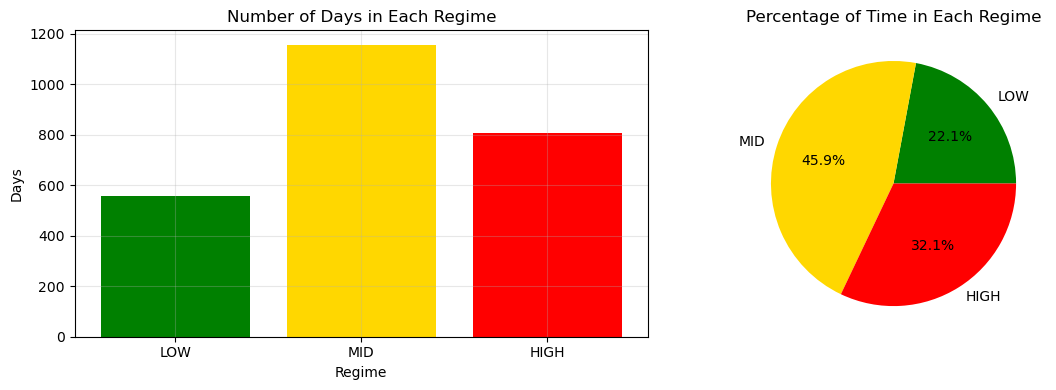


Regime Distribution:
  LOW: 556 days (22.1%)
  MID: 1156 days (45.9%)
  HIGH: 808 days (32.1%)


In [75]:
# Plot 3: Time spent in each regime
regime_counts = df['vol_regime'].value_counts().reindex(['LOW', 'MID', 'HIGH'])
regime_pct = regime_counts / regime_counts.sum() * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['green', 'gold', 'red']
axes[0].bar(regime_counts.index, regime_counts.values, color=colors)
axes[0].set_xlabel('Regime')
axes[0].set_ylabel('Days')
axes[0].set_title('Number of Days in Each Regime')

axes[1].pie(regime_pct.values, labels=regime_pct.index, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Percentage of Time in Each Regime')

plt.tight_layout()
plt.show()

print("\nRegime Distribution:")
for regime in ['LOW', 'MID', 'HIGH']:
    print(f"  {regime}: {regime_counts[regime]} days ({regime_pct[regime]:.1f}%)")

## 5. Regime Statistics Validation

In [76]:
# Verify that regimes actually differ in realized volatility
print("Annualized Realized Volatility by Regime:")
print("="*50)

for regime in ['LOW', 'MID', 'HIGH']:
    regime_rets = df.loc[df['vol_regime'] == regime, 'mkt_ret']
    ann_vol = regime_rets.std() * np.sqrt(252)
    mean_ret = regime_rets.mean() * 252  # Annualized
    sharpe = mean_ret / ann_vol if ann_vol > 0 else 0
    print(f"  {regime:5s}: Vol={ann_vol*100:5.1f}%, Ret={mean_ret*100:6.2f}%, Sharpe={sharpe:.2f}")

Annualized Realized Volatility by Regime:
  LOW  : Vol=  2.0%, Ret=  1.41%, Sharpe=0.70
  MID  : Vol=  7.9%, Ret=  0.93%, Sharpe=0.12
  HIGH : Vol= 19.2%, Ret= 18.90%, Sharpe=0.98


## 6. Regime-Based Trading Strategy Backtest

Using external analysis, we identified stocks that perform best and worst in each volatility regime:

**Strategy:**
- **HIGH Volatility**: Long N, M, K | Short D
- **MID Volatility**: Long Y, V, C, K | Short R, I
- **LOW Volatility**: Long V | Short E

We backtest this strategy using the HMM regime predictions.

In [77]:
# Define the regime-based strategy
STRATEGY = {
    'HIGH': {
        'long': ['N', 'M', 'K'],
        'short': ['D']
    },
    'MID': {
        'long': ['Y', 'V', 'C', 'K'],
        'short': ['R', 'I']
    },
    'LOW': {
        'long': ['V'],
        'short': ['E']
    }
}

print("Trading Strategy by Regime:")
print("="*50)
for regime in ['HIGH', 'MID', 'LOW']:
    long_str = ', '.join(STRATEGY[regime]['long']) if STRATEGY[regime]['long'] else 'None'
    short_str = ', '.join(STRATEGY[regime]['short']) if STRATEGY[regime]['short'] else 'None'
    print(f"{regime:5s}: Long [{long_str}] | Short [{short_str}]")

Trading Strategy by Regime:
HIGH : Long [N, M, K] | Short [D]
MID  : Long [Y, V, C, K] | Short [R, I]
LOW  : Long [V] | Short [E]


In [78]:
def calculate_strategy_returns(df, strategy):
    """
    Calculate daily strategy returns based on HMM regime predictions.
    
    For each day:
    - Identify the regime from HMM
    - Equal-weight long positions in specified stocks
    - Equal-weight short positions in specified stocks
    - Net position is (avg long return) - (avg short return)
    
    Returns:
    --------
    pd.Series: Daily strategy returns
    """
    strategy_returns = []
    
    for date, row in df.iterrows():
        regime = row['vol_regime']
        
        long_stocks = strategy[regime]['long']
        short_stocks = strategy[regime]['short']
        
        # Calculate long return (equal-weighted)
        if long_stocks:
            long_ret = row[long_stocks].mean()
        else:
            long_ret = 0
        
        # Calculate short return (equal-weighted, negative because we're shorting)
        if short_stocks:
            short_ret = -row[short_stocks].mean()
        else:
            short_ret = 0
        
        # Total return: long + short (dollar-neutral if equal weight on both sides)
        # Normalize by number of legs to get per-dollar return
        n_legs = (1 if long_stocks else 0) + (1 if short_stocks else 0)
        if n_legs > 0:
            daily_ret = (long_ret + short_ret) / n_legs
        else:
            daily_ret = 0
            
        strategy_returns.append(daily_ret)
    
    return pd.Series(strategy_returns, index=df.index, name='strategy_return')


# Calculate strategy returns
strategy_rets = calculate_strategy_returns(df, STRATEGY)
df['strategy_return'] = strategy_rets

# Calculate cumulative returns
df['strategy_cumret'] = (1 + df['strategy_return']).cumprod()
df['market_cumret'] = (1 + df['mkt_ret']).cumprod()

print(f"Strategy returns calculated for {len(df)} days")
print(f"Final cumulative return: {df['strategy_cumret'].iloc[-1]:.2f}x")

Strategy returns calculated for 2520 days
Final cumulative return: 6.17x


In [79]:
def calculate_backtest_stats(returns, trading_days_per_year=252):
    """
    Calculate comprehensive backtest statistics.
    
    Parameters:
    -----------
    returns : pd.Series
        Daily returns
    trading_days_per_year : int
        Number of trading days for annualization
        
    Returns:
    --------
    dict: Dictionary of statistics
    """
    returns = returns.dropna()
    n_days = len(returns)
    n_years = n_days / trading_days_per_year
    
    # Basic stats
    total_return = (1 + returns).prod() - 1
    cagr = (1 + total_return) ** (1 / n_years) - 1
    
    # Volatility
    ann_vol = returns.std() * np.sqrt(trading_days_per_year)
    
    # Sharpe Ratio (assuming 0 risk-free rate)
    ann_return = returns.mean() * trading_days_per_year
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Sortino Ratio (downside deviation)
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() * np.sqrt(trading_days_per_year)
    sortino = ann_return / downside_std if downside_std > 0 else 0
    
    # Maximum Drawdown
    cumret = (1 + returns).cumprod()
    rolling_max = cumret.cummax()
    drawdown = (cumret - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Calmar Ratio
    calmar = cagr / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win rate
    win_rate = (returns > 0).mean()
    
    # Average win/loss
    avg_win = returns[returns > 0].mean() if (returns > 0).any() else 0
    avg_loss = returns[returns < 0].mean() if (returns < 0).any() else 0
    profit_factor = abs(avg_win * (returns > 0).sum() / (avg_loss * (returns < 0).sum())) if avg_loss != 0 else np.inf
    
    return {
        'Total Return': total_return,
        'CAGR': cagr,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar,
        'Win Rate': win_rate,
        'Avg Win': avg_win,
        'Avg Loss': avg_loss,
        'Profit Factor': profit_factor,
        'N Days': n_days,
        'N Years': n_years
    }


# Calculate stats for strategy and market
strategy_stats = calculate_backtest_stats(df['strategy_return'])
market_stats = calculate_backtest_stats(df['mkt_ret'])

print("BACKTEST STATISTICS")
print("="*70)
print(f"{'Metric':<25} {'Strategy':>15} {'Market':>15}")
print("-"*70)

metrics_to_show = [
    ('Total Return', '{:.1%}'),
    ('CAGR', '{:.1%}'),
    ('Annualized Volatility', '{:.1%}'),
    ('Sharpe Ratio', '{:.2f}'),
    ('Sortino Ratio', '{:.2f}'),
    ('Max Drawdown', '{:.1%}'),
    ('Calmar Ratio', '{:.2f}'),
    ('Win Rate', '{:.1%}'),
    ('Profit Factor', '{:.2f}'),
]

for metric, fmt in metrics_to_show:
    strat_val = fmt.format(strategy_stats[metric])
    mkt_val = fmt.format(market_stats[metric])
    print(f"{metric:<25} {strat_val:>15} {mkt_val:>15}")

BACKTEST STATISTICS
Metric                           Strategy          Market
----------------------------------------------------------------------
Total Return                       517.4%           83.3%
CAGR                                20.0%            6.2%
Annualized Volatility               30.8%           12.2%
Sharpe Ratio                         0.75            0.56
Sortino Ratio                        1.15            0.96
Max Drawdown                       -44.9%          -19.2%
Calmar Ratio                         0.44            0.33
Win Rate                            52.9%           51.1%
Profit Factor                        1.13            1.09


## 7. PnL Visualization

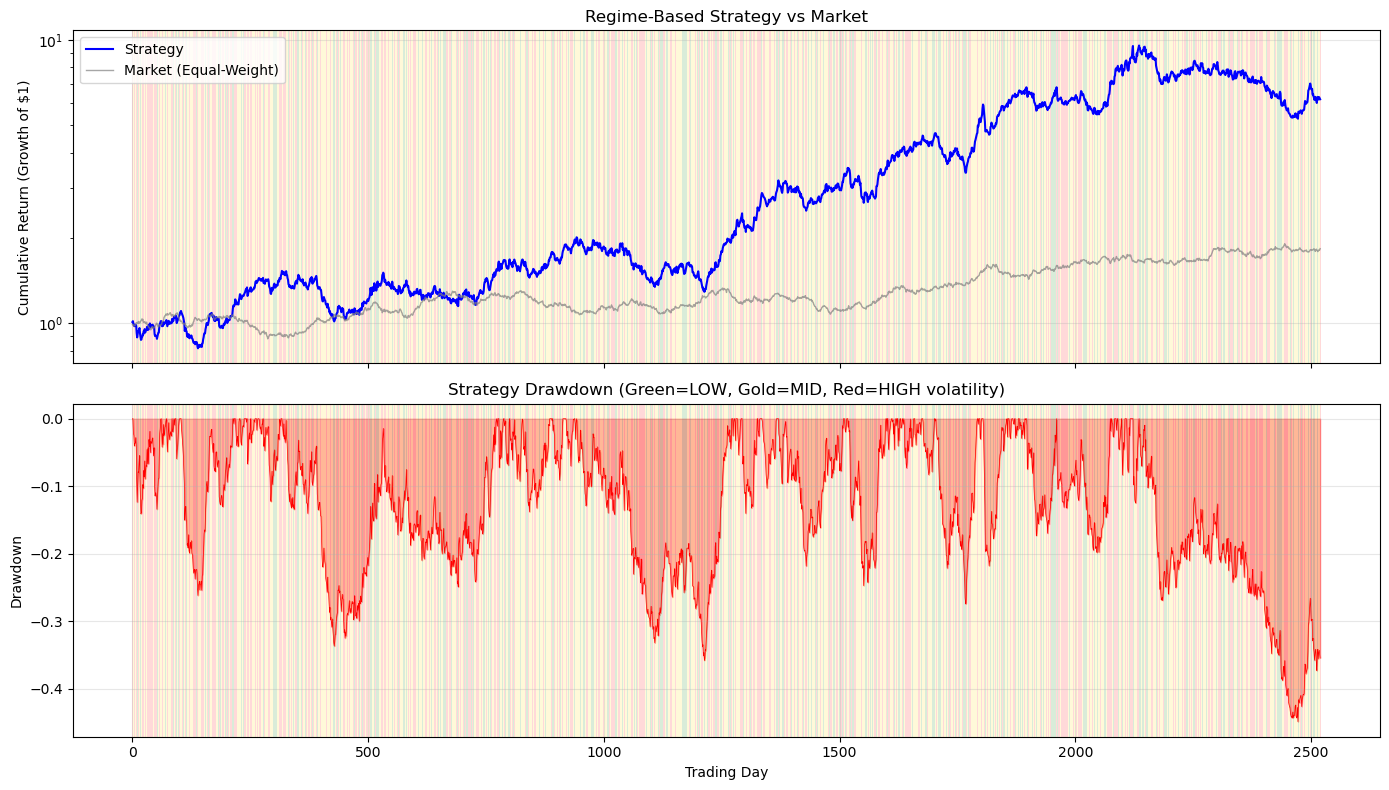


Final Values:
  Strategy: $6.17 (from $1)
  Market:   $1.83 (from $1)


In [80]:
# Plot cumulative returns with regime shading
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Cumulative Returns
ax1 = axes[0]
ax1.plot(range(len(df)), df['strategy_cumret'], label='Strategy', color='blue', linewidth=1.5)
ax1.plot(range(len(df)), df['market_cumret'], label='Market (Equal-Weight)', color='gray', linewidth=1, alpha=0.7)

# Shade by regime
shade_regime_blocks(ax1, df['vol_regime'], alpha=0.15)

ax1.set_ylabel('Cumulative Return (Growth of $1)')
ax1.set_title('Regime-Based Strategy vs Market')
ax1.legend(loc='upper left')
ax1.set_yscale('log')

# Plot 2: Drawdown
cumret = df['strategy_cumret']
rolling_max = cumret.cummax()
drawdown = (cumret - rolling_max) / rolling_max

ax2 = axes[1]
ax2.fill_between(range(len(df)), drawdown.values, 0, color='red', alpha=0.3)
ax2.plot(range(len(df)), drawdown.values, color='red', linewidth=0.5)
shade_regime_blocks(ax2, df['vol_regime'], alpha=0.15)

ax2.set_xlabel('Trading Day')
ax2.set_ylabel('Drawdown')
ax2.set_title('Strategy Drawdown (Green=LOW, Gold=MID, Red=HIGH volatility)')

plt.tight_layout()
plt.show()

print(f"\nFinal Values:")
print(f"  Strategy: ${df['strategy_cumret'].iloc[-1]:.2f} (from $1)")
print(f"  Market:   ${df['market_cumret'].iloc[-1]:.2f} (from $1)")

In [81]:
# Performance breakdown by regime
print("STRATEGY PERFORMANCE BY REGIME")
print("="*70)
print(f"{'Regime':<8} {'Days':>6} {'Ann.Ret':>10} {'Ann.Vol':>10} {'Sharpe':>8} {'Contrib':>10}")
print("-"*70)

total_contrib = 0
for regime in ['LOW', 'MID', 'HIGH']:
    regime_rets = df.loc[df['vol_regime'] == regime, 'strategy_return']
    n_days = len(regime_rets)
    ann_ret = regime_rets.mean() * 252
    ann_vol = regime_rets.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    
    # Contribution to total return
    regime_total = (1 + regime_rets).prod() - 1
    total_contrib += regime_total
    
    print(f"{regime:<8} {n_days:>6} {ann_ret:>9.1%} {ann_vol:>9.1%} {sharpe:>8.2f} {regime_total:>9.1%}")

STRATEGY PERFORMANCE BY REGIME
Regime     Days    Ann.Ret    Ann.Vol   Sharpe    Contrib
----------------------------------------------------------------------
LOW         556     17.5%     43.4%     0.40     19.7%
MID        1156     31.4%     22.1%     1.42    276.4%
HIGH        808     14.6%     31.0%     0.47     37.1%


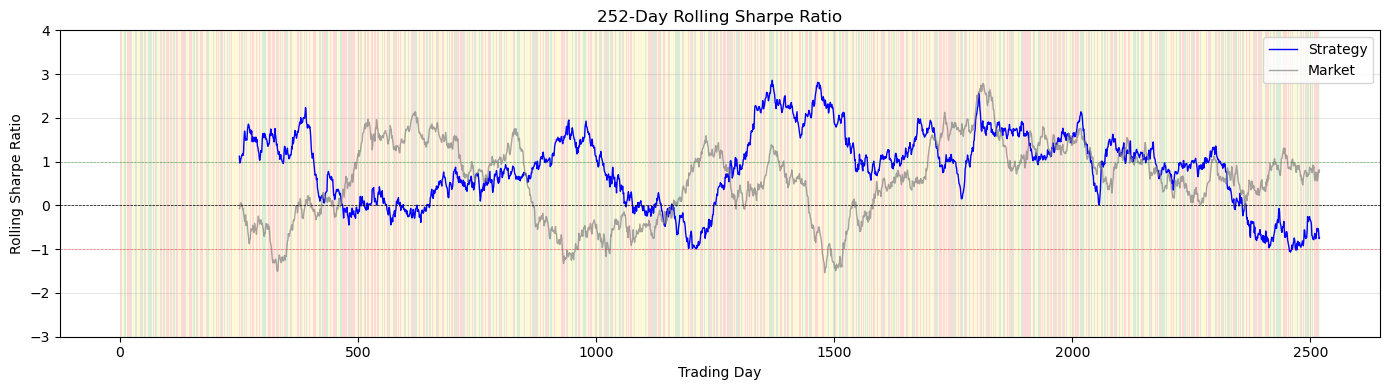

In [83]:
# Rolling Sharpe ratio comparison
ROLLING_WINDOW = 252  # 1-year rolling

rolling_sharpe_strat = (
    df['strategy_return'].rolling(ROLLING_WINDOW).mean() / 
    df['strategy_return'].rolling(ROLLING_WINDOW).std()
) * np.sqrt(252)

rolling_sharpe_mkt = (
    df['mkt_ret'].rolling(ROLLING_WINDOW).mean() / 
    df['mkt_ret'].rolling(ROLLING_WINDOW).std()
) * np.sqrt(252)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(range(len(df)), rolling_sharpe_strat, label='Strategy', color='blue', linewidth=1)
ax.plot(range(len(df)), rolling_sharpe_mkt, label='Market', color='gray', linewidth=1, alpha=0.7)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.axhline(1, color='green', linewidth=0.5, linestyle='--', alpha=0.5)
ax.axhline(-1, color='red', linewidth=0.5, linestyle='--', alpha=0.5)

shade_regime_blocks(ax, df['vol_regime'], alpha=0.15)

ax.set_xlabel('Trading Day')
ax.set_ylabel('Rolling Sharpe Ratio')
ax.set_title(f'{ROLLING_WINDOW}-Day Rolling Sharpe Ratio')
ax.legend(loc='upper right')
ax.set_ylim(-3, 4)
plt.tight_layout()
plt.show()

## 8. Export Results

In [84]:
# Export backtest results
export_df = df[['mkt_ret', 'vol_regime', 'strategy_return', 'strategy_cumret', 'market_cumret']].copy()
export_df.to_csv('hmm_strategy_backtest.csv')
print("Backtest results exported to hmm_strategy_backtest.csv")

# Export statistics to CSV
stats_df = pd.DataFrame({
    'Strategy': strategy_stats,
    'Market': market_stats
})
stats_df.to_csv('backtest_statistics.csv')
print("Statistics exported to backtest_statistics.csv")

Backtest results exported to hmm_strategy_backtest.csv
Statistics exported to backtest_statistics.csv


## 9. Summary

In [85]:
print("="*70)
print("HMM REGIME-BASED TRADING STRATEGY - SUMMARY")
print("="*70)

# Count stocks (exclude non-stock columns)
stock_cols = [c for c in df.columns if len(c) == 1 and c.isalpha()]

print(f"\nData: {len(df)} trading days, {len(stock_cols)} stocks (excluded: {EXCLUDED_STOCKS})")
print(f"HMM: {N_STATES} states, {N_ITER} iterations, {N_RESTARTS} restarts")

print(f"\nStrategy:")
for regime in ['HIGH', 'MID', 'LOW']:
    long_str = ', '.join(STRATEGY[regime]['long']) if STRATEGY[regime]['long'] else 'None'
    short_str = ', '.join(STRATEGY[regime]['short']) if STRATEGY[regime]['short'] else 'None'
    print(f"  {regime:5s}: Long [{long_str}] | Short [{short_str}]")

print(f"\nKey Results:")
print(f"  CAGR:          {strategy_stats['CAGR']:.1%} (vs Market: {market_stats['CAGR']:.1%})")
print(f"  Sharpe Ratio:  {strategy_stats['Sharpe Ratio']:.2f} (vs Market: {market_stats['Sharpe Ratio']:.2f})")
print(f"  Sortino Ratio: {strategy_stats['Sortino Ratio']:.2f} (vs Market: {market_stats['Sortino Ratio']:.2f})")
print(f"  Max Drawdown:  {strategy_stats['Max Drawdown']:.1%} (vs Market: {market_stats['Max Drawdown']:.1%})")
print(f"  Total Return:  {strategy_stats['Total Return']:.1%} (vs Market: {market_stats['Total Return']:.1%})")

print(f"\nNote: This is an in-sample backtest. Out-of-sample testing recommended.")

HMM REGIME-BASED TRADING STRATEGY - SUMMARY

Data: 2520 trading days, 22 stocks (excluded: ['F', 'G', 'J'])
HMM: 3 states, 3000 iterations, 30 restarts

Strategy:
  HIGH : Long [N, M, K] | Short [D]
  MID  : Long [Y, V, C, K] | Short [R, I]
  LOW  : Long [V] | Short [E]

Key Results:
  CAGR:          20.0% (vs Market: 6.2%)
  Sharpe Ratio:  0.75 (vs Market: 0.56)
  Sortino Ratio: 1.15 (vs Market: 0.96)
  Max Drawdown:  -44.9% (vs Market: -19.2%)
  Total Return:  517.4% (vs Market: 83.3%)

Note: This is an in-sample backtest. Out-of-sample testing recommended.


## 10. Individual Stock Performance by Regime

Detailed breakdown of returns for each stock in our strategy, within each volatility regime.

**Calculation methodology:**
- **Daily returns**: Directly from `prices.pct_change()` 
- **Ann. Return**: `mean(daily_returns) * 252`
- **Total Return**: `product(1 + daily_returns) - 1` (cumulative return over regime days)
- **Ann. Vol**: `std(daily_returns) * sqrt(252)`
- **Sharpe**: `Ann. Return / Ann. Vol`

In [86]:
def get_stock_stats_by_regime(df, stocks, regime):
    """Calculate performance stats for a list of stocks in a specific regime."""
    regime_df = df[df['vol_regime'] == regime]
    n_days = len(regime_df)
    
    results = []
    for stock in stocks:
        stock_rets = regime_df[stock].dropna()
        
        ann_ret = stock_rets.mean() * 252
        ann_vol = stock_rets.std() * np.sqrt(252)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
        total_ret = (1 + stock_rets).prod() - 1
        
        results.append({
            'Stock': stock,
            'Ann. Return': ann_ret,
            'Ann. Vol': ann_vol,
            'Sharpe': sharpe,
            'Total Return': total_ret
        })
    
    return pd.DataFrame(results).set_index('Stock')


# Display individual stock performance for each regime
for regime in ['HIGH', 'MID', 'LOW']:
    print(f"\n{'='*70}")
    print(f"{regime} VOLATILITY REGIME - Individual Stock Returns")
    print(f"{'='*70}")
    
    n_days = (df['vol_regime'] == regime).sum()
    print(f"Days in regime: {n_days}")
    
    long_stocks = STRATEGY[regime]['long']
    short_stocks = STRATEGY[regime]['short']
    
    # Long positions
    if long_stocks:
        print(f"\nLONG POSITIONS: {', '.join(long_stocks)}")
        print("-"*60)
        long_stats = get_stock_stats_by_regime(df, long_stocks, regime)
        print(f"{'Stock':<8} {'Ann.Ret':>12} {'Ann.Vol':>12} {'Sharpe':>10} {'Total Ret':>12}")
        print("-"*60)
        for stock in long_stocks:
            row = long_stats.loc[stock]
            print(f"{stock:<8} {row['Ann. Return']:>11.1%} {row['Ann. Vol']:>11.1%} {row['Sharpe']:>10.2f} {row['Total Return']:>11.1%}")
        
        # Average of longs
        avg_long_ret = long_stats['Ann. Return'].mean()
        avg_long_sharpe = long_stats['Sharpe'].mean()
        print(f"{'Avg':<8} {avg_long_ret:>11.1%} {'-':>11} {avg_long_sharpe:>10.2f} {'-':>11}")
    
    # Short positions
    if short_stocks:
        print(f"\nSHORT POSITIONS: {', '.join(short_stocks)}")
        print("-"*60)
        short_stats = get_stock_stats_by_regime(df, short_stocks, regime)
        print(f"{'Stock':<8} {'Ann.Ret':>12} {'Ann.Vol':>12} {'Sharpe':>10} {'Total Ret':>12}")
        print(f"{'':8} {'(raw)':>12} {'':>12} {'(raw)':>10} {'(raw)':>12}")
        print("-"*60)
        for stock in short_stocks:
            row = short_stats.loc[stock]
            # Show raw returns (negative = good for short)
            print(f"{stock:<8} {row['Ann. Return']:>11.1%} {row['Ann. Vol']:>11.1%} {row['Sharpe']:>10.2f} {row['Total Return']:>11.1%}")
        
        # Average of shorts (raw)
        avg_short_ret = short_stats['Ann. Return'].mean()
        avg_short_sharpe = short_stats['Sharpe'].mean()
        print(f"{'Avg':<8} {avg_short_ret:>11.1%} {'-':>11} {avg_short_sharpe:>10.2f} {'-':>11}")
        print(f"\n  * Short P&L = -{avg_short_ret:.1%} annualized (we profit when stocks go down)")
    else:
        print(f"\nSHORT POSITIONS: None")


HIGH VOLATILITY REGIME - Individual Stock Returns
Days in regime: 808

LONG POSITIONS: N, M, K
------------------------------------------------------------
Stock         Ann.Ret      Ann.Vol     Sharpe    Total Ret
------------------------------------------------------------
N              43.9%       49.5%       0.89      175.8%
M              30.4%       38.7%       0.78      108.3%
K               4.8%       58.8%       0.08      -32.9%
Avg            26.3%           -       0.58           -

SHORT POSITIONS: D
------------------------------------------------------------
Stock         Ann.Ret      Ann.Vol     Sharpe    Total Ret
                (raw)                   (raw)        (raw)
------------------------------------------------------------
D              -2.9%       54.2%      -0.05      -43.2%
Avg            -2.9%           -      -0.05           -

  * Short P&L = --2.9% annualized (we profit when stocks go down)

MID VOLATILITY REGIME - Individual Stock Returns
Days in re

In [87]:
# Create summary table of all strategy stocks across regimes
all_strategy_stocks = set()
for regime in STRATEGY:
    all_strategy_stocks.update(STRATEGY[regime]['long'])
    all_strategy_stocks.update(STRATEGY[regime]['short'])

all_strategy_stocks = sorted(all_strategy_stocks)

print("\n" + "="*80)
print("SUMMARY: All Strategy Stocks - Annualized Returns by Regime")
print("="*80)

summary_data = []
for stock in all_strategy_stocks:
    row = {'Stock': stock}
    for regime in ['HIGH', 'MID', 'LOW']:
        regime_df = df[df['vol_regime'] == regime]
        ann_ret = regime_df[stock].mean() * 252
        row[f'{regime}_Ret'] = ann_ret
        
        # Mark if this stock is long/short in this regime
        if stock in STRATEGY[regime]['long']:
            row[f'{regime}_Position'] = 'LONG'
        elif stock in STRATEGY[regime]['short']:
            row[f'{regime}_Position'] = 'SHORT'
        else:
            row[f'{regime}_Position'] = '-'
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data).set_index('Stock')

# Display
print(f"\n{'Stock':<6} {'HIGH Ret':>10} {'Pos':>6} {'MID Ret':>10} {'Pos':>6} {'LOW Ret':>10} {'Pos':>6}")
print("-"*70)
for stock in all_strategy_stocks:
    row = summary_df.loc[stock]
    high_ret = row['HIGH_Ret']
    mid_ret = row['MID_Ret']
    low_ret = row['LOW_Ret']
    high_pos = row['HIGH_Position']
    mid_pos = row['MID_Position']
    low_pos = row['LOW_Position']
    print(f"{stock:<6} {high_ret:>9.1%} {high_pos:>6} {mid_ret:>9.1%} {mid_pos:>6} {low_ret:>9.1%} {low_pos:>6}")

print("\nNote: 'LONG' = we buy, 'SHORT' = we sell short, '-' = no position")


SUMMARY: All Strategy Stocks - Annualized Returns by Regime

Stock    HIGH Ret    Pos    MID Ret    Pos    LOW Ret    Pos
----------------------------------------------------------------------
C          -7.4%      -     39.0%   LONG     14.9%      -
D          -2.9%  SHORT    -12.0%      -     12.6%      -
E          35.0%      -     -0.2%      -    -18.0%  SHORT
I          26.3%      -    -35.3%  SHORT    -11.7%      -
K           4.8%   LONG     31.9%   LONG     59.6%      -
M          30.4%   LONG      9.0%      -     10.3%      -
N          43.9%   LONG     10.8%      -     11.6%      -
R          41.6%      -    -36.0%  SHORT    -24.5%      -
V          47.3%      -      4.9%   LONG     17.1%   LONG
Y          36.1%      -     32.5%   LONG     19.4%      -

Note: 'LONG' = we buy, 'SHORT' = we sell short, '-' = no position


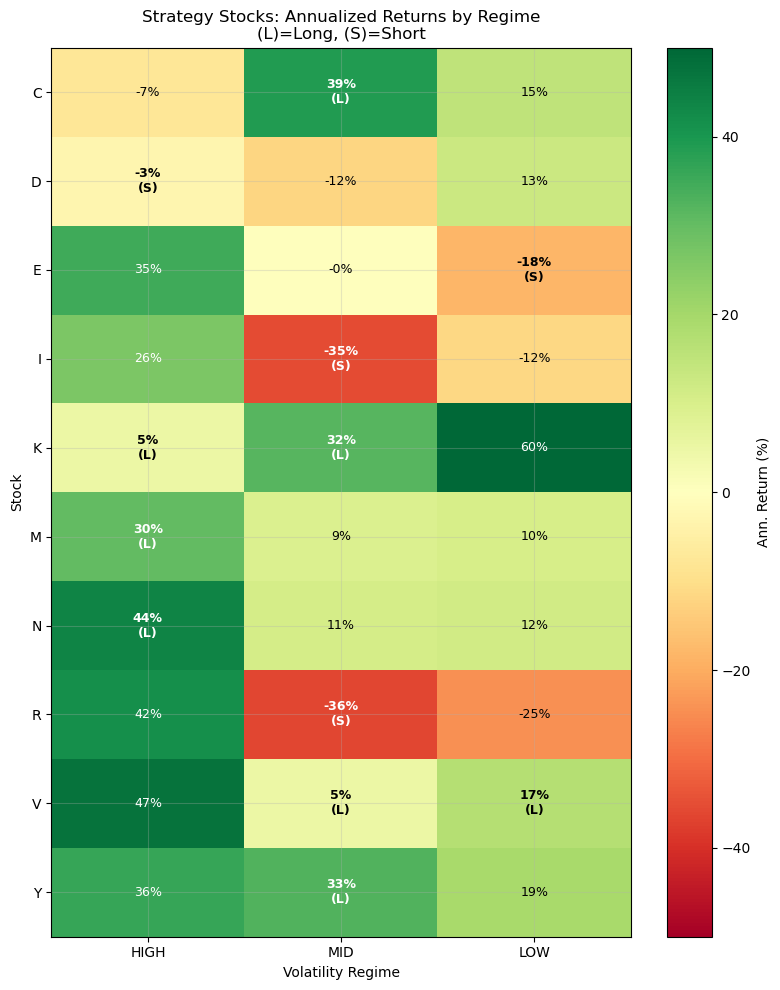

In [88]:
# Visual heatmap of strategy stock returns by regime
returns_matrix = summary_df[['HIGH_Ret', 'MID_Ret', 'LOW_Ret']] * 100  # Convert to percentage
returns_matrix.columns = ['HIGH', 'MID', 'LOW']

fig, ax = plt.subplots(figsize=(8, 10))

im = ax.imshow(returns_matrix.values, cmap='RdYlGn', aspect='auto', vmin=-50, vmax=50)

ax.set_xticks(range(len(returns_matrix.columns)))
ax.set_xticklabels(returns_matrix.columns)
ax.set_yticks(range(len(returns_matrix.index)))
ax.set_yticklabels(returns_matrix.index)

# Add values and position markers
for i, stock in enumerate(returns_matrix.index):
    for j, regime in enumerate(returns_matrix.columns):
        val = returns_matrix.iloc[i, j]
        pos = summary_df.loc[stock, f'{regime}_Position']
        
        # Color based on value
        color = 'white' if abs(val) > 25 else 'black'
        
        # Add position marker
        if pos == 'LONG':
            marker = f'{val:.0f}%\n(L)'
        elif pos == 'SHORT':
            marker = f'{val:.0f}%\n(S)'
        else:
            marker = f'{val:.0f}%'
        
        ax.text(j, i, marker, ha='center', va='center', color=color, fontsize=9, fontweight='bold' if pos != '-' else 'normal')

ax.set_xlabel('Volatility Regime')
ax.set_ylabel('Stock')
ax.set_title('Strategy Stocks: Annualized Returns by Regime\n(L)=Long, (S)=Short')
plt.colorbar(im, ax=ax, label='Ann. Return (%)')
plt.tight_layout()
plt.show()

In [89]:
# Summary table for ALL stocks (excluding L, O, Q, F, G, J)
EXCLUDE_FROM_SUMMARY = ['L', 'O', 'Q', 'F', 'G', 'J']

# Get all stock columns
all_stocks = [c for c in df.columns if len(c) == 1 and c.isalpha() and c not in EXCLUDE_FROM_SUMMARY]
all_stocks = sorted(all_stocks)

print("="*85)
print("ALL STOCKS - Annualized Returns by Regime (Excluding L, O, Q, F, G, J)")
print("="*85)

all_stock_data = []
for stock in all_stocks:
    row = {'Stock': stock}
    for regime in ['HIGH', 'MID', 'LOW']:
        regime_df = df[df['vol_regime'] == regime]
        ann_ret = regime_df[stock].mean() * 252
        row[f'{regime}_Ret'] = ann_ret
        
        # Mark if this stock is long/short in this regime
        if stock in STRATEGY[regime]['long']:
            row[f'{regime}_Pos'] = 'L'
        elif stock in STRATEGY[regime]['short']:
            row[f'{regime}_Pos'] = 'S'
        else:
            row[f'{regime}_Pos'] = ''
    all_stock_data.append(row)

all_stocks_df = pd.DataFrame(all_stock_data).set_index('Stock')

# Display
print(f"\n{'Stock':<6} {'HIGH Ret':>10} {'':>3} {'MID Ret':>10} {'':>3} {'LOW Ret':>10} {'':>3}")
print("-"*55)
for stock in all_stocks:
    row = all_stocks_df.loc[stock]
    high_ret = row['HIGH_Ret']
    mid_ret = row['MID_Ret']
    low_ret = row['LOW_Ret']
    high_pos = row['HIGH_Pos']
    mid_pos = row['MID_Pos']
    low_pos = row['LOW_Pos']
    print(f"{stock:<6} {high_ret:>9.1%} {high_pos:>3} {mid_ret:>9.1%} {mid_pos:>3} {low_ret:>9.1%} {low_pos:>3}")

print("\nL = Long position in strategy, S = Short position in strategy")
print(f"Excluded from display: {EXCLUDE_FROM_SUMMARY}")

ALL STOCKS - Annualized Returns by Regime (Excluding L, O, Q, F, G, J)

Stock    HIGH Ret        MID Ret        LOW Ret    
-------------------------------------------------------
A          -0.4%          9.1%         18.9%    
B          -6.1%         -1.5%         -2.5%    
C          -7.4%         39.0%   L     14.9%    
D          -2.9%   S    -12.0%         12.6%    
E          35.0%         -0.2%        -18.0%   S
H          -6.3%          7.2%          4.9%    
I          26.3%        -35.3%   S    -11.7%    
K           4.8%   L     31.9%   L     59.6%    
M          30.4%   L      9.0%         10.3%    
N          43.9%   L     10.8%         11.6%    
P          10.1%         -7.5%        -26.3%    
R          41.6%        -36.0%   S    -24.5%    
S          16.3%         -2.4%         -3.5%    
T          -4.0%         -2.8%         -4.2%    
U          21.4%        -30.0%          5.3%    
V          47.3%          4.9%   L     17.1%   L
W          45.0%         12.3%      